# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

In [2]:
# Import libraries for building model
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.regularizers import l2
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 20

### Plotting Function

In [5]:
def plot(model):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(model.history['loss'])   
    axes[0].plot(model.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(model.history['categorical_accuracy'])   
    axes[1].plot(model.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size,tot_frames,frames,img_height,img_width):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,tot_frames-1,frames)).astype(int) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image,(img_height,img_width))
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        
        remaining_image = len(folder_list)%batch_size
        batch += 1
        if(remaining_image!=0):
            batch_data = np.zeros((remaining_image,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    image = resize(image,(img_height,img_width))
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

#### Function for Building Model

In [7]:
# Function to build model
def buildmodel(model,epoch_size,batch_size,l_rate,tot_frames,frames,img_height,img_width): 
    # Optimizer and compile
    if l_rate==0:
        optimiser = keras.optimizers.Adam()
    else:
        optimiser = keras.optimizers.Adam(l_rate)
    # Compiling the model
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    
    # Create Generators
    # Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
    train_generator = generator(train_path, train_doc, batch_size,tot_frames,frames,img_height,img_width)
    val_generator = generator(val_path, val_doc, batch_size,tot_frames,frames,img_height,img_width)
   
    # Save h5 files
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(model_name):
        os.mkdir(model_name)
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
    callbacks_list = [checkpoint, LR]
    
    # The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() 
    # calls it need to make.
    # Epoch Calculation
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    # Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save 
    # the model at the end of each epoch.
    # Build Model
    model1 =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    plot(model1)
    return model1

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Conv3D - Model No - 1:

# training sequences = 663
# validation sequences = 100
# epochs = 15


2022-06-14 07:44:43.895706: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-14 07:44:43.895787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                        

2022-06-14 07:44:48.484788: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.8706 - categorical_accuracy: 0.3741Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2022-06-1407_44_43.092002/model-00001-1.87056-0.37406-4.14708-0.16000.h5
34/34 [==============================] - 94s 3s/step - loss: 1.8706 - categorical_accuracy: 0.3741 - val_loss: 4.1471 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.5482 - categorical_accuracy: 0.4359
Epoch 00002: saving model to model_init_2022-06-1407_44_43.092002/model-00002-1.54822-0.43590-3.44485-0.13000.h5
34/34 [==============================] - 88s 3s/step - loss: 1.5482 - categorical_accuracy: 0.4359 - val_loss: 3.4448 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.4151 - categorical_accuracy: 0.5023
Epoch 00003: saving model to model_init_2022-06-1407_44_43.092002/mode

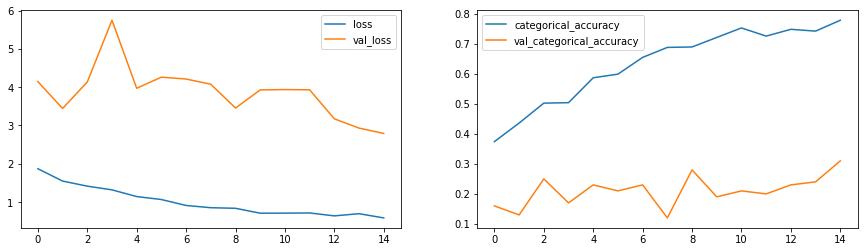

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20 #experiment with the batch size

num_classes = 5
filtersize=(3,3,3)
dropout=0.5
dense_neurons=256

tot_frames = 30
frames = 16 
img_height = 120
img_width = 120

# Input
input_shape=(frames,img_height,img_width,3)

model = Sequential()

model.add(Conv3D(16, filtersize, padding='same',input_shape=input_shape,strides=(1, 1, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv3D(16, filtersize, padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2),strides=(2,2,2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2),strides=(2,2,2)))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2),strides=(2,2,2)))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2),strides=(2,2,2)))
        

model.add(Flatten())
model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(num_classes,activation='softmax'))

model_3d_1 = buildmodel(model,num_epochs,batch_size,0,tot_frames,frames,img_height,img_width)

**Training Accuracy is more than validation Accuracy, hence Over fitting.**

## Conv3D - Model No - 2:

# training sequences = 663
# validation sequences = 100
# epochs = 15
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_9 (Conv3D)           (None, 16, 120, 120, 32)  13856     
                                                                 
 activation_9 (Activation)   (None, 16, 120, 120, 32)  0         
                                                                 
 batch_normalization_11 (Bat  (None, 16, 120, 120,

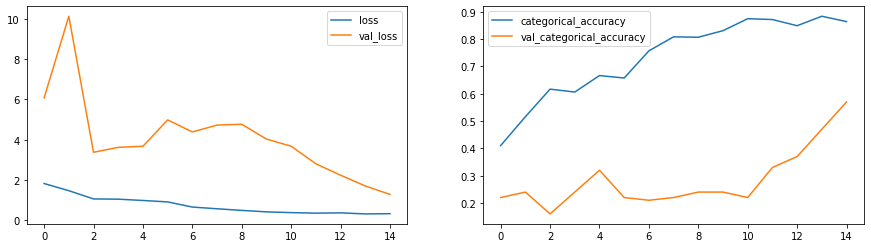

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20 #experiment with the batch size

num_classes = 5
filtersize=(3,3,3)
dropout=0.5
dense_neurons=256

tot_frames = 30
frames = 16 
img_height = 120
img_width = 120

# Input
input_shape=(frames,img_height,img_width,3)

model = Sequential()

model.add(Conv3D(16, filtersize, padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv3D(32, filtersize, padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(256, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
model.add(Flatten())
model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(num_classes,activation='softmax'))

model_3d_2 = buildmodel(model,num_epochs,batch_size,0,tot_frames,frames,img_height,img_width)

**Better than Previous model, but still Over fitting.**

## Conv3D - Model No - 3:

# training sequences = 663
# validation sequences = 100
# epochs = 15


2022-06-14 11:22:11.169481: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-14 11:22:11.169561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  400       
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 60, 60, 32)     0

2022-06-14 11:22:17.062488: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 1.9446 - categorical_accuracy: 0.3786Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2022-06-1411_22_10.277693/model-00001-1.94457-0.37858-2.61371-0.21000.h5
23/23 [==============================] - 94s 4s/step - loss: 1.9446 - categorical_accuracy: 0.3786 - val_loss: 2.6137 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.3326 - categorical_accuracy: 0.5445
Epoch 00002: saving model to model_init_2022-06-1411_22_10.277693/model-00002-1.33262-0.54449-3.27038-0.22000.h5
23/23 [==============================] - 89s 4s/step - loss: 1.3326 - categorical_accuracy: 0.5445 - val_loss: 3.2704 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.3312 - categorical_accuracy: 0.5385
Epoch 00003: saving model to model_init_2022-06-1411_22_10.277693/mode

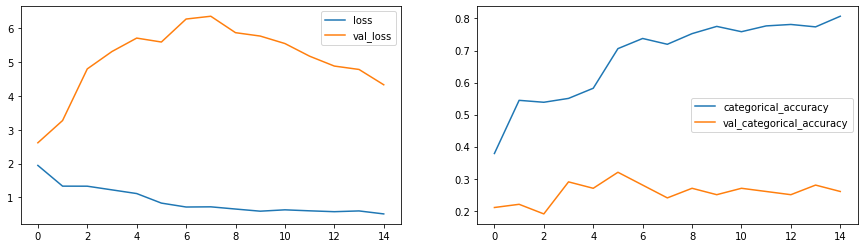

In [10]:
#changes==batch size= 30, filter_size=(2,2,2),
#write your model here
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 30 #experiment with the batch size

num_classes = 5
filtersize=(2,2,2)
dropout=0.5
dense_neurons=128

tot_frames = 30
frames = 16 
img_height = 120
img_width = 120

# Input
input_shape=(frames,img_height,img_width,3)


model = Sequential()

model.add(Conv3D(16, filtersize, padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
                
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

model.add(Flatten())
model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(num_classes,activation='softmax'))

model_3d_3 = buildmodel(model,num_epochs,batch_size,0,tot_frames,frames,img_height,img_width)

**Overfitting has Increased drastically,  Let's trying adding more layers.**

## Conv3D - Model No - 4:

# training sequences = 663
# validation sequences = 100
# epochs = 15
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_6 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_8 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 conv3d_7 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_7 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_9 (Batc  (None, 16, 120, 120,

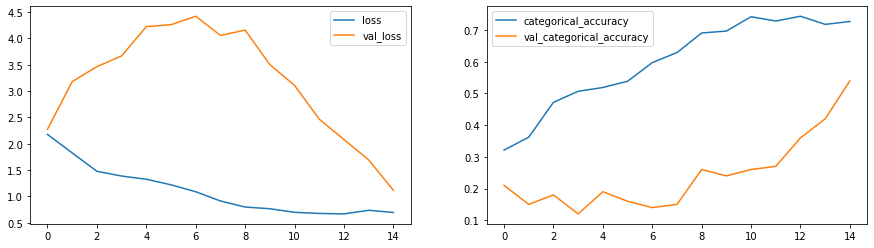

In [11]:
#changes==batch size= 20, filter_size=(3,3,3),dense_neurons=256,  added more layers.

#write your model here
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20 #experiment with the batch size

num_classes = 5
filtersize=(3,3,3)
dropout=0.5
dense_neurons=256

tot_frames = 30
frames = 16 
img_height = 120
img_width = 120

# Input
input_shape=(frames,img_height,img_width,3)

model = Sequential()

model.add(Conv3D(16, filtersize, padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(16, filtersize, padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
                
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

model.add(Flatten())
model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(num_classes,activation='softmax'))

model_3d_4 = buildmodel(model,num_epochs,batch_size,0,tot_frames,frames,img_height,img_width)

**Not Much of Improvement with this model. Let's try adding dropouts.**

## Conv3D - Model No - 5:


# training sequences = 663
# validation sequences = 100
# epochs = 15
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_13 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_17 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_14 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_14 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 16, 120, 120,

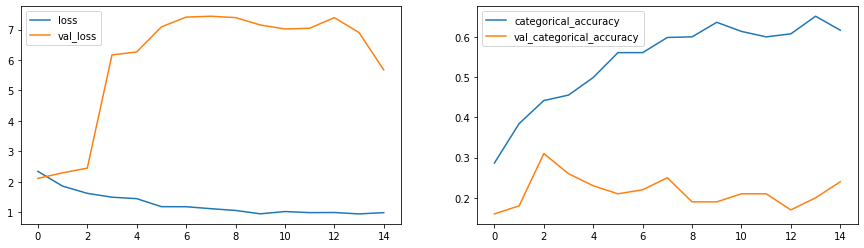

In [17]:
#changes==batch size= 20, filter_size=(3,3,3),dense_neurons=256,  added more layers.
#Adding dropout at convolution layers

#write your model here
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20 #experiment with the batch size

num_classes = 5
filtersize=(3,3,3)
dropout=0.5
dense_neurons=256

tot_frames = 30
frames = 16 
img_height = 120
img_width = 120

# Input
input_shape=(frames,img_height,img_width,3)

model = Sequential()

model.add(Conv3D(16, filtersize, padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(16, filtersize, padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
                
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(dropout))

    
model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(dropout))


model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(dropout))


model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(dropout))

        

model.add(Flatten())
model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(num_classes,activation='softmax'))

model_3d_5 = buildmodel(model,num_epochs,batch_size,0,tot_frames,frames,img_height,img_width)

**Overfitting Increased.Let's try to reduce the parameters**

## Conv3D - Model No - 6:

# training sequences = 663
# validation sequences = 100
# epochs = 20
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_21 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_27 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_22 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                  

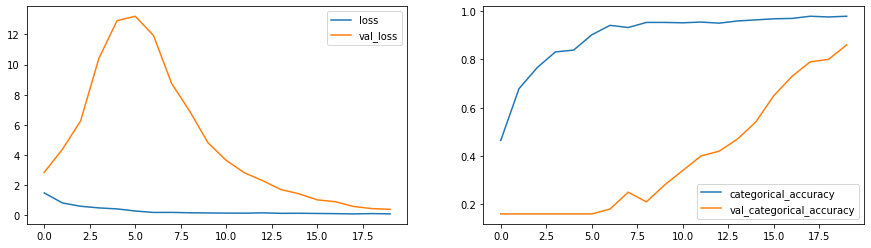

In [18]:
#Reducing the number of parameters

#write your model here
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20#choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20 #experiment with the batch size

num_classes = 5
filtersize=(2,2,2)
dropout=0.25
dense_neurons=128

tot_frames = 30
frames = 16 
img_height = 120
img_width = 120

# Input
input_shape=(frames,img_height,img_width,3)

model = Sequential()

model.add(Conv3D(16, filtersize, padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
                
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

model.add(Flatten())
model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(num_classes,activation='softmax'))

model_3d_6 = buildmodel(model,num_epochs,batch_size,0.001,tot_frames,frames,img_height,img_width)

**Got best training and validation Accuracies, hence finalizing this model.**

## Models Using Conv2D layers + LSTM Layer 

## Conv2D layers + LSTM Layer - model-1

# training sequences = 663
# validation sequences = 100
# epochs = 15
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_79 (TimeDi  (None, 20, 80, 80, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_80 (TimeDi  (None, 20, 80, 80, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_81 (TimeDi  (None, 20, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 dropout_27 (Dropout)        (None, 20, 40, 40, 16)    0         
                                                                 
 time_distributed_82 (TimeDi  (None, 20, 40, 40, 

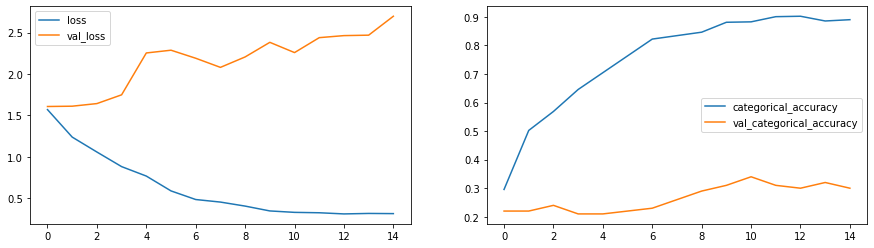

In [35]:
# Features
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 40 #experiment with the batch size

dropout = 0.25
num_classes = 5
lstm_cells=64
dense_neurons=[128,64,32]

tot_frames = 30
frames = 20 
img_height = 160
img_width = 160

# Input
input_shape=(frames,img_height,img_width,3)

# Defining the Model
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(128, (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_neurons[0], activation='relu'))
model.add(Dense(dense_neurons[1], activation='relu'))
model.add(Dense(dense_neurons[2], activation='relu'))
model.add(Dropout(dropout))

## using LSTM as the RNN model.
model.add(LSTM(lstm_cells, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax')) # using Softmax as last layer

## Build model
model_2d_1 = buildmodel(model,num_epochs,batch_size,0,tot_frames,frames,img_height,img_width)


**Training Accuracy is more than validation Accuracy, hence Over fitting.**

## Conv2D layers + LSTM Layer - model-2

# training sequences = 663
# validation sequences = 100
# epochs = 20
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_92 (TimeDi  (None, 20, 80, 80, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_93 (TimeDi  (None, 20, 80, 80, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_94 (TimeDi  (None, 20, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 dropout_33 (Dropout)        (None, 20, 40, 40, 16)    0         
                                                                 
 time_distributed_95 (TimeDi  (None, 20, 40, 40, 

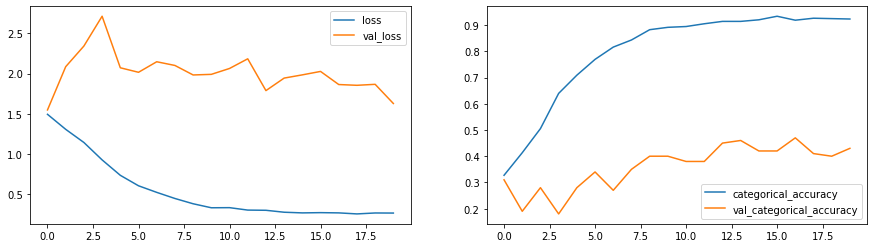

In [36]:
# Features
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20 #experiment with the batch size

dropout = 0.25
num_classes = 5
lstm_cells=64
dense_neurons=[128,64,32]

tot_frames = 30
frames = 20 
img_height = 160
img_width = 160

# Input
input_shape=(frames,img_height,img_width,3)

# Defining the Model
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(128, (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_neurons[0], activation='relu'))
model.add(Dense(dense_neurons[1], activation='relu'))
model.add(Dense(dense_neurons[2], activation='relu'))
model.add(Dropout(dropout))

## using LSTM as the RNN model.
model.add(LSTM(lstm_cells, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax')) # using Softmax as last layer

## Build model
model_2d_2 = buildmodel(model,num_epochs,batch_size,0,tot_frames,frames,img_height,img_width)


**Better than Previous model, but still Over fitting.**

## Conv2D layers + LSTM Layer - model-3

# training sequences = 663
# validation sequences = 100
# epochs = 20
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_118 (TimeD  (None, 16, 60, 60, 16)   448       
 istributed)                                                     
                                                                 
 time_distributed_119 (TimeD  (None, 16, 60, 60, 16)   64        
 istributed)                                                     
                                                                 
 time_distributed_120 (TimeD  (None, 16, 30, 30, 16)   0         
 istributed)                                                     
                                                                 
 dropout_45 (Dropout)        (None, 16, 30, 30, 16)    0         
                                                                 
 time_distributed_121 (TimeD  (None, 16, 30, 30, 

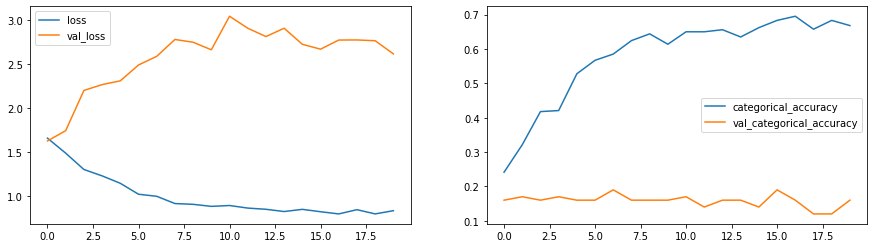

In [38]:
# Features
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 30 #experiment with the batch size

dropout = 0.5
num_classes = 5
lstm_cells=128
dense_neurons=[128,64,32]

tot_frames = 30
frames = 16
img_height = 120
img_width = 120

# Input
input_shape=(frames,img_height,img_width,3)

# Defining the Model
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(128, (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_neurons[0], activation='relu'))
model.add(Dense(dense_neurons[1], activation='relu'))
model.add(Dense(dense_neurons[2], activation='relu'))
model.add(Dropout(dropout))

## using LSTM as the RNN model.
model.add(LSTM(lstm_cells, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax')) # using Softmax as last layer

## Build model
model_2d_3 = buildmodel(model,num_epochs,batch_size,0,tot_frames,frames,img_height,img_width)


**When we try to reduce the Params, the accuracy is decreasing by a huge margin.**

## Conv2D layers + LSTM Layer - model-4

# training sequences = 663
# validation sequences = 100
# epochs = 20
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_117 (TimeD  (None, 16, 60, 60, 16)   448       
 istributed)                                                     
                                                                 
 time_distributed_118 (TimeD  (None, 16, 60, 60, 16)   64        
 istributed)                                                     
                                                                 
 time_distributed_119 (TimeD  (None, 16, 30, 30, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_120 (TimeD  (None, 16, 30, 30, 32)   4640      
 istributed)                                                     
                                                  

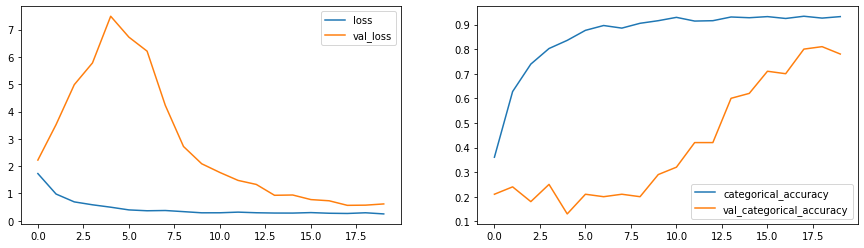

In [16]:
# Features
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20 #experiment with the batch size

dropout = 0.25
num_classes = 5
lstm_cells=128
dense_neurons=64

tot_frames = 30
frames = 16
img_height = 120
img_width = 120

# Input
input_shape=(frames,img_height,img_width,3)

model = Sequential()
        
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same',strides=(2, 2),activation='relu'),
          input_shape= input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2),strides=(2, 2))))
                
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2),strides=(2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2),strides=(2, 2))))
                
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2),strides=(2, 2))))
                
model.add(Flatten())
model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(num_classes,activation='softmax'))

## Build model
model2d_6 = buildmodel(model,num_epochs,batch_size,0.0002,tot_frames,frames,img_height,img_width)

**As per observation, increasing the params have increased the model performance but slightly Overfitting.**

## Conv2D layers + LSTM Layer - model-5

# training sequences = 663
# validation sequences = 100
# epochs = 20
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_102 (TimeD  (None, 18, 60, 60, 16)   448       
 istributed)                                                     
                                                                 
 time_distributed_103 (TimeD  (None, 18, 60, 60, 16)   64        
 istributed)                                                     
                                                                 
 time_distributed_104 (TimeD  (None, 18, 30, 30, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_105 (TimeD  (None, 18, 30, 30, 32)   4640      
 istributed)                                                     
                                                  

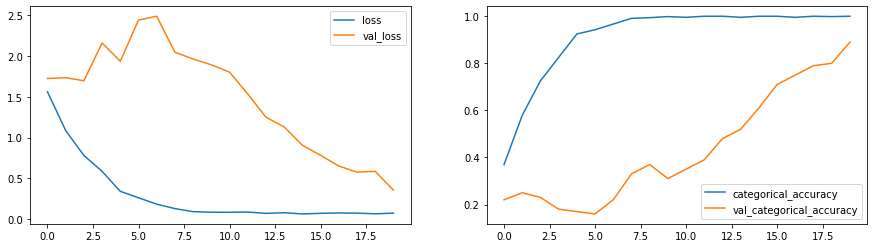

In [15]:
# Features
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20 #experiment with the batch size

dropout = 0.25
num_classes = 5
lstm_cells=128
dense_neurons = [128,64,32,5]

tot_frames = 30
frames = 18
img_height = 120
img_width = 120

# Input
input_shape=(frames,img_height,img_width,3)

model = Sequential()
        
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', strides=(2, 2),activation='relu'),
          input_shape= input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
                
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
                
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
                
model.add(Flatten())
model.add(Dense(dense_neurons[0],activation='relu'))
model.add(Dense(dense_neurons[1],activation='relu'))
model.add(Dense(dense_neurons[2],activation='relu'))

model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(num_classes,activation='softmax'))

## Build model
model2d_7 = buildmodel(model,num_epochs,batch_size,0,tot_frames,frames,img_height,img_width)

**Not much improvement comparing to the previous model**

## CNN LSTM with GRU

# training sequences = 663
# validation sequences = 100
# epochs = 20
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_189 (TimeD  (None, 16, 3, 3, 1024)   3228864   
 istributed)                                                     
                                                                 
 time_distributed_190 (TimeD  (None, 16, 3, 3, 1024)   4096      
 istributed)                                                     
                                                                 
 time_distributed_191 (TimeD  (None, 16, 1, 1, 1024)   0         
 istributed)                                                     
                                                                 
 time_distributed_192 (TimeD  (None, 16, 1024)         0         
 istributed)                                                     
                                                 

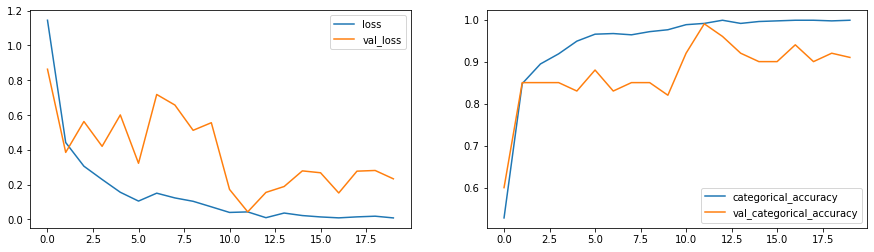

In [41]:
#importing mobilenet for GRU
from tensorflow.keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
# Features
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 15 #experiment with the batch size

dropout = 0.25
num_classes = 5
gru_cells=128
dense_neurons = 128

tot_frames = 30
frames = 16
img_height = 120
img_width = 120

# Input
input_shape=(frames,img_height,img_width,3)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
 
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(gru_cells))
model.add(Dropout(dropout))
        
model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))
        
model.add(Dense(num_classes, activation='softmax'))

## Build model
model_2d_GRU = buildmodel(model,num_epochs,batch_size,0,tot_frames,frames,img_height,img_width)

**Though the model is very good, the params are very high, hence avoiding this model keeping the computational cost into consideration.**

**As per our Observation, the final Model suitable for Gesture recognition is Model no: 6, with categorical training accuracy : 97.89, Validation accuracy : 86.00, Training Loss: 0.1054, Validation Loss: 0.4075.
Params of the model 6:
Image_size= 120*120
Frames= 16
Batch Size= 20
Epochs= 20
Number of Classes= 5
Filter_size= (2,2,2)**
